In [1]:
# these lines install modules cleantext and emoji. 
# Module cleantext is used to clean text data including: conversion of texts to lower case, removing unecessary panctuation and removal of stopwords.
# module emoji is needed to remove emocations from text.
!pip install cleantext
!pip install emoji
!pip install wget

  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=6d6a85e736ebe0ef7a41014c9c605f828388ff4d61c31d682bb8f7bf95977d3d
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [2]:
# here are all the modules used during this analysis. 
# you can use help() to get documentation of each, eg help('pandas') will give you documentation of pandas

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import cleantext 
import emoji 
import tensorflow as tf
import tensorflow_addons as tfa 
from tensorflow.keras import datasets, layers, models,Input,Model
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, Conv2D, BatchNormalization, MaxPooling2D, Flatten, LSTM, Dense, Lambda, Dropout,Reshape,GlobalAveragePooling1D
import re
import keras
import shutil
import string
import random
import requests
from sklearn.cluster import KMeans
from sklearn import metrics
import wget
import zipfile
import os
from sklearn.metrics import (confusion_matrix,accuracy_score)
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV
from functools import reduce
from sklearn.tree import DecisionTreeClassifier as DR
from sklearn.ensemble import GradientBoostingClassifier as GBoost

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from wordcloud import WordCloud,STOPWORDS, ImageColorGenerator
import pickle
from sklearn.decomposition import PCA
# call backs
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss',mode='min', verbose=1, patience=20)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
2022-12-05 06:58:28.221444: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-05 06:58:28.221561: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-05 06:58:28.222553: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [3]:
with open("/kaggle/input/fakerealmainoutputdata/kmea.pkl","rb") as file:
    kmea=pickle.load(file)
    
with open("/kaggle/input/fakerealmainoutputdata/predictors.pkl","rb") as file:
    predictors=pickle.load(file)
    
with open("/kaggle/input/fakerealmainoutputdata/tests.pkl","rb") as file:
    tests=pickle.load(file)
    
test=tf.data.experimental.load("/kaggle/input/fakerealmainoutputdata/train")
train=tf.data.experimental.load("/kaggle/input/missingtest/train")
valid=tf.data.experimental.load("/kaggle/input/fakerealmainoutputdata/valid")
model = keras.models.load_model('/kaggle/input/fakerealmainoutputdata/model')

2022-12-05 06:58:28.326532: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [4]:
# some parameters to be used
# some of this were relevantduring code creation
batch_size=64  #  Batch sizes to use
epoch =200       # number of training ephochs
sequence_length = 250   # here we can set arguments for text vectorization      
max_tokens=20000

vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,
    pad_to_max_tokens=True,
    output_mode='int')

train_article = train.map(lambda x, y: x)
vectorize_layer.adapt(train_article)


def vectorize_articles(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

AUTOTUNE = tf.data.AUTOTUNE 
train = train.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  # set catching and prefetching on training data
valid = valid.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)  #set catching and prefetching on testing data
test = test.map(vectorize_articles).cache().prefetch(buffer_size=AUTOTUNE)    #  set catching and prefetching on validation data

2022-12-05 06:58:43.635752: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


# Baseline methods
 
**_The proposed approach will be compared to currently existing classifiers including decision trees, K nearest neighbor algorithm, SVM, and boosted classification tree, regarding the time complexity and classification accuracy.  Two types of feature extraction methods will be considered, features extracted using Convolution neural networks and TF-IDF features. _**

In [5]:
def labels(ds):
    labels=[]
    for batch in ds:
        articles,labelss=batch
        labelss=labelss.numpy()
        labels.append(labelss)
    labels=np.concatenate(labels)
    return labels

label_train=np.argmax(labels(train),axis=1)
label_test=np.argmax(labels(test),axis=1)
label_valid=np.argmax(labels(valid),axis=1)

In [6]:
feature_miner=Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="Bidirectional2").output,name="feature_miner"
)

In [7]:
feature_miner.summary()

Model: "feature_miner"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_articles (InputLayer)  [(None, None)]            0         
_________________________________________________________________
embeddinglayer (Embedding)   (None, None, 100)         2000100   
_________________________________________________________________
dropout (Dropout)            (None, None, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 8)           4008      
_________________________________________________________________
dropout1 (Dropout)           (None, None, 8)           0         
_________________________________________________________________
batchnormalization (BatchNor (None, None, 8)           32        
_________________________________________________________________
Bidirectional2 (Bidirectiona (None, 16)              

In [8]:
X_train=predictors
y_train=label_train
X_test=tests
y_test=label_test
X_valid=feature_miner.predict(valid)
y_valid=label_valid

## K nearest neighbor model
**_This is an unsupervised ML model which works by classing training data into groups. New data is classified based on similarity to the trained data (Taunk et al., 2019). The model needs a similarity metric to establish the level of similarity between articles. Because the vectorized articles are in numeric form, Euclidean distance method will be used as the similarity measure (Hu et al., 2016)._**

Here We first extract features from the main data. these features act as the predictor values for the benchmark models. Similarly the labels will also be prepared for use.

When performing Knearest neighbour classification. The number of neigbourhoods(k) to consider impacts model performance. Here grid search will be used to to find the appropriate number of K to consider.

In [9]:

KNNmodel =KNN(n_neighbors = 2,n_jobs=-1)
KNNmod =KNNmodel.fit(X_train,y_train)
# grid search
param={"n_neighbors":range(2,100)}
tuned=GridSearchCV(KNNmod,param_grid=param,cv=3,verbose=3,n_jobs=-1,return_train_score=True)
tuned.fit(X_train,y_train)
KNNmodel =KNN(**tuned.best_params_,n_jobs=-1)
KNNmod =KNNmodel.fit(X_train,y_train)
tuned.best_params_

Fitting 3 folds for each of 98 candidates, totalling 294 fits


{'n_neighbors': 28}

In [10]:
with open("KNNtuned.pkl","wb") as file:
    pickle.dump(tuned,file)
    
with open("KNNmod.pkl","wb") as file:
    pickle.dump(KNNmod,file)

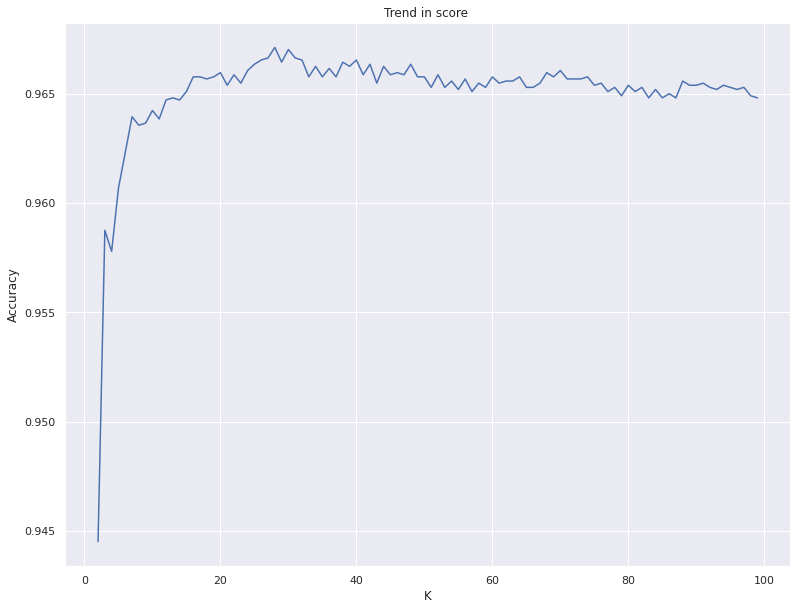

In [11]:
sns.set(rc={"figure.figsize":(13, 10)}) 
sns.lineplot(data=tuned.cv_results_,x='param_n_neighbors',y='mean_test_score')
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title('Trend in score ')
plt.savefig('KNNgrindsearch.png')

Here are is the performance on the testing set

In [12]:
predictions=KNNmod.predict(X_test)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'KNN':[metrics.accuracy_score(y_test,predictions),
                        metrics.recall_score(y_test, predictions,pos_label=0),
                        metrics.recall_score(y_test, predictions,pos_label=1),
                        metrics.precision_score(y_test,predictions,pos_label=0),
                        metrics.f1_score(y_test,predictions,pos_label=0)]})

,Measure,KNN
0,Accuracy,0.902564
1,Sensitivity,0.465217
2,Specitivity,0.961047
3,Precision,0.614943
4,F1_score,0.529703


** performance on the validation set.**

In [13]:
predictions=KNNmod.predict(X_valid)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'KNN':[metrics.accuracy_score(y_valid,predictions),
                        metrics.recall_score(y_valid, predictions,pos_label=0),
                        metrics.recall_score(y_valid, predictions,pos_label=1),
                        metrics.precision_score(y_valid,predictions,pos_label=0),
                        metrics.f1_score(y_valid,predictions,pos_label=0)]})

,Measure,KNN
0,Accuracy,0.901538
1,Sensitivity,0.444444
2,Specitivity,0.958478
3,Precision,0.571429
4,F1_score,0.500000


# Support Vector Machine

The SVM is a supervised ML model which uses kernel functions to map data into a high dimensional space in order to perform classification (Deris et al., 2011). Its major functions includes; linear, RBF and polynomial kernel.

A variety of Parameter combination will be tested to come up with the best combination

In [14]:
# tuning hyper parameter
params={"gamma":['scale','auto'],
 "tol":[0.001,0.01,0.1],
 "C":[1.0,3.0,5.0,7.0,8.0,9.0],
 "kernel":['linear','poly', 'rbf','sigmoid']}

In [15]:
SVCmod = SVC(random_state = 0)
random=SVCmod.fit(X_train,y_train)
# Grid search
np.random.seed(10)
tuned=GridSearchCV(SVCmod,param_grid=params,cv=3,verbose=3,n_jobs=-1)
tuned.fit(X_train,y_train)
model = SVC(**tuned.best_params_)
model=model.fit(X_train,y_train)
tuned.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV 1/3] END .n_neighbors=2;, score=(train=0.975, test=0.939) total time=   1.1s
[CV 2/3] END .n_neighbors=3;, score=(train=0.975, test=0.955) total time=   1.2s
[CV 3/3] END .n_neighbors=4;, score=(train=0.972, test=0.961) total time=   1.2s
[CV 1/3] END .n_neighbors=6;, score=(train=0.968, test=0.964) total time=   1.5s
[CV 2/3] END .n_neighbors=7;, score=(train=0.969, test=0.960) total time=   1.2s
[CV 3/3] END .n_neighbors=8;, score=(train=0.968, test=0.967) total time=   1.2s
[CV 1/3] END n_neighbors=10;, score=(train=0.968, test=0.965) total time=   1.1s
[CV 2/3] END n_neighbors=11;, score=(train=0.969, test=0.961) total time=   1.1s
[CV 3/3] END n_neighbors=12;, score=(train=0.966, test=0.966) total time=   1.2s
[CV 1/3] END n_neighbors=14;, score=(train=0.968, test=0.966) total time=   1.2s
[CV 2/3] END n_neighbors=15;, score=(train=0.969, test=0.962) total time=   1.1s
[CV 3/3] END n_neighbors=16;, score=(train=0.9

{'C': 7.0, 'gamma': 'scale', 'kernel': 'rbf', 'tol': 0.1}

In [16]:
with open("SVCtuned.pkl","wb") as file:
    pickle.dump(tuned,file)
    
with open("svcmod.pkl","wb") as file:
    pickle.dump(model,file)

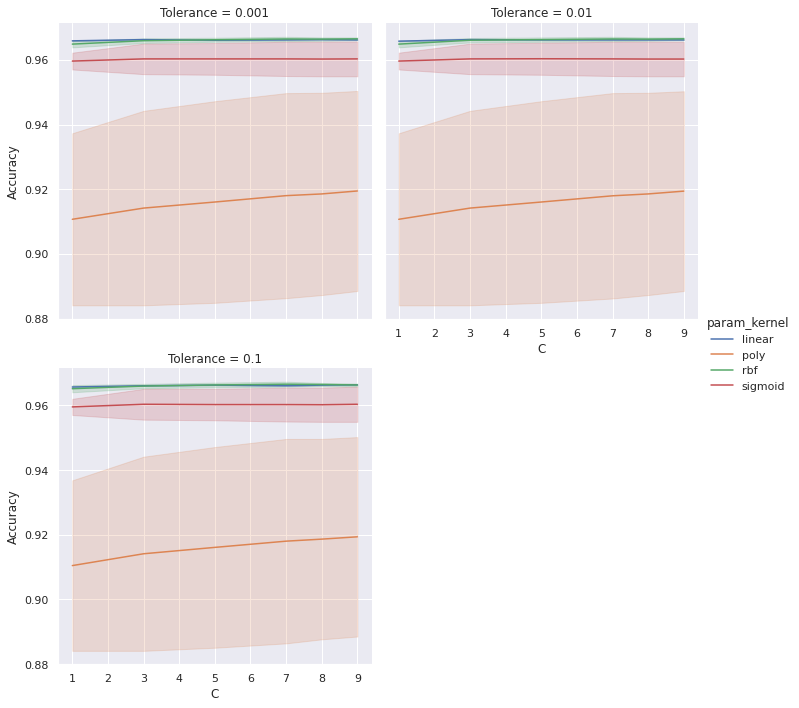

In [17]:
dat=pd.DataFrame(tuned.cv_results_)
dat.rename(columns = {'param_C':'C','param_tol':'Tolerance',
                              'mean_test_score':'Accuracy'}, inplace = True)
g = sns.FacetGrid(dat,
                  height=5, col='Tolerance',
                  hue='param_kernel',col_wrap=2)
g.map_dataframe(sns.lineplot,x='C',y='Accuracy')
g.add_legend()

plt.savefig('KNNgrindsearch.png')

In [18]:
predictions=model.predict(X_test)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'SVM':[metrics.accuracy_score(y_test,predictions),
                        metrics.recall_score(y_test, predictions,pos_label=0),
                        metrics.recall_score(y_test, predictions,pos_label=1),
                        metrics.precision_score(y_test,predictions,pos_label=0),
                        metrics.f1_score(y_test,predictions,pos_label=0)]})

,Measure,SVM
0,Accuracy,0.906154
1,Sensitivity,0.452174
2,Specitivity,0.966860
3,Precision,0.645963
4,F1_score,0.531969


In [19]:
predictions=model.predict(X_valid)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'SVM':[metrics.accuracy_score(y_valid,predictions),
                        metrics.recall_score(y_valid, predictions,pos_label=0),
                        metrics.recall_score(y_valid, predictions,pos_label=1),
                        metrics.precision_score(y_valid,predictions,pos_label=0),
                        metrics.f1_score(y_valid,predictions,pos_label=0)]})

,Measure,SVM
0,Accuracy,0.907692
1,Sensitivity,0.458333
2,Specitivity,0.963668
3,Precision,0.611111
4,F1_score,0.523810


# Decision trees 

This is a supervised machine learning classifier which works by binary splitting to classify data into the multiple outcomes. The splitting starts with a single node, and then splits training data into subgroups (nodes) based on the feature most related to the outcome variable. Each subgroup is further split based on the feature most related to the outcome variable on those subgroups. This continues until all nodes become pure or cannot be split further. The most common measures of node impurity/purity are Gini and entropy (Jijo, 2021).

In [20]:
# tuning hyper parameter
parameters={"splitter":["best","random"],
            "max_depth" : [5,10,15,20],
           "min_samples_leaf":[3,6,9,12],
           "min_weight_fraction_leaf":[0.0,0.2,0.3,0.4],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,30,60,90]}

In [21]:
np.random.seed(10)
model = DR( max_depth=10)
model=model.fit(X_train,y_train)
tuning_model=GridSearchCV(model,param_grid=parameters,cv=3,verbose=3,n_jobs=-1)
np.random.seed(10)
tuning_model.fit(X_train,y_train)
tuning_model.best_params_

Fitting 3 folds for each of 2048 candidates, totalling 6144 fits

[CV 1/3] END C=3.0, gamma=scale, kernel=rbf, tol=0.1;, score=0.968 total time=   0.7s
[CV 2/3] END C=3.0, gamma=scale, kernel=sigmoid, tol=0.001;, score=0.948 total time=   0.4s
[CV 3/3] END C=3.0, gamma=scale, kernel=sigmoid, tol=0.01;, score=0.958 total time=   0.4s
[CV 1/3] END C=3.0, gamma=auto, kernel=linear, tol=0.001;, score=0.967 total time=   0.5s
[CV 2/3] END C=3.0, gamma=auto, kernel=linear, tol=0.01;, score=0.963 total time=   0.4s
[CV 3/3] END C=3.0, gamma=auto, kernel=linear, tol=0.1;, score=0.968 total time=   0.5s
[CV 1/3] END C=3.0, gamma=auto, kernel=poly, tol=0.01;, score=0.884 total time=   1.1s
[CV 2/3] END C=3.0, gamma=auto, kernel=poly, tol=0.1;, score=0.884 total time=   1.1s
[CV 3/3] END C=3.0, gamma=auto, kernel=rbf, tol=0.001;, score=0.968 total time=   0.8s
[CV 1/3] END C=3.0, gamma=auto, kernel=rbf, tol=0.1;, score=0.966 total time=   0.7s
[CV 2/3] END C=3.0, gamma=auto, kernel=sigmoid, tol=0

{'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': 60,
 'min_samples_leaf': 12,
 'min_weight_fraction_leaf': 0.0,
 'splitter': 'random'}

In [22]:

model1 = DR(**tuning_model.best_params_)
model=model1.fit(X_train,y_train)
predictions=model.predict(X_test)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'Decision tree':[metrics.accuracy_score(y_test,predictions),
                        metrics.recall_score(y_test, predictions,pos_label=0),
                        metrics.recall_score(y_test, predictions,pos_label=1),
                        metrics.precision_score(y_test,predictions,pos_label=0),
                        metrics.f1_score(y_test,predictions,pos_label=0)]})

,Measure,Decision tree
0,Accuracy,0.902564
1,Sensitivity,0.478261
2,Specitivity,0.959302
3,Precision,0.611111
4,F1_score,0.536585


In [23]:
with open("tuning_model.pkl","wb") as file:
    pickle.dump(tuning_model,file)
    
with open("DR.pkl","wb") as file:
    pickle.dump(model,file)

In [24]:
predictions=model.predict(X_valid)
pd.DataFrame({'Measure':['Accuracy','Sensitivity','Specitivity','Precision','F1_score'],
             'Decision tree':[metrics.accuracy_score(y_valid,predictions),
                        metrics.recall_score(y_valid, predictions,pos_label=0),
                        metrics.recall_score(y_valid, predictions,pos_label=1),
                        metrics.precision_score(y_valid,predictions,pos_label=0),
                        metrics.f1_score(y_valid,predictions,pos_label=0)]})

,Measure,Decision tree
0,Accuracy,0.901538
1,Sensitivity,0.458333
2,Specitivity,0.956747
3,Precision,0.568966
4,F1_score,0.507692
